## Imports

In [12]:
import kagglehub as kh
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import os

## Download e Leitura dos Dados

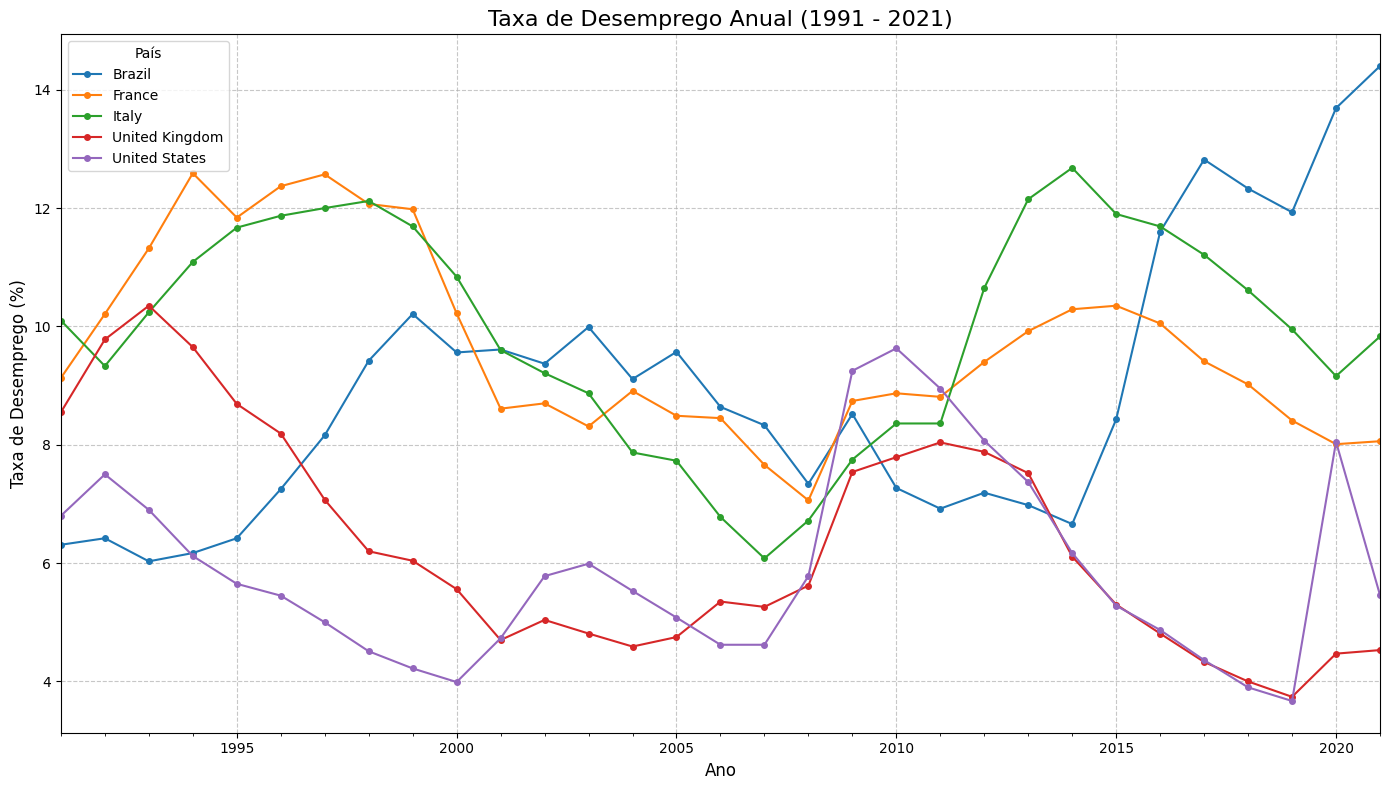

In [13]:
# Dataset de Desemprego (Anual, Global)
path_unemp_global = kh.dataset_download("pantanjali/unemployment-dataset")
csv_unemp_global_path = os.path.join(path_unemp_global, 'unemployment analysis.csv')

# Dataset de Inflação (Anual, Global)
path_infl_global = kh.dataset_download("sazidthe1/global-inflation-data")
csv_infl_global_path = os.path.join(path_infl_global, 'global_inflation_data.csv')

# Ler CSV de Desemprego (Dados Anuais por País)
df_unemp_global = pd.read_csv(csv_unemp_global_path)

# Ler CSV de Inflação (Dados Anuais por País)
df_inflation_global = pd.read_csv(csv_infl_global_path)

# Criar diretório de saída
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

df_unemp_long = df_unemp_global.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars= [col for col in df_unemp_global.columns if col.isdigit()],
    var_name='year',
    value_name='unemployment'
)

# Conversão
df_unemp_long['year'] = pd.to_datetime(df_unemp_long['year'], format='%Y')
df_unemp_long = df_unemp_long.set_index('year').sort_index()

# Filtrar os países
countries = ['Brazil', 'France', 'Italy', 'United States', 'United Kingdom']
df_filtered = df_unemp_long[df_unemp_long['Country Name'].isin(countries)].copy()

df_plot = df_filtered.pivot_table(
    index=df_filtered.index,
    columns='Country Name',
    values='unemployment'
)

plt.figure(figsize=(14, 8))
df_plot.plot(
    kind='line',
    ax=plt.gca(),
    marker='o',
    markersize=4
)

plt.title('Taxa de Desemprego Anual (1991 - 2021)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Desemprego (%)', fontsize=12)
plt.legend(title='País', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## Tratamento e Merge dos Dados

In [14]:
# --- Tratamento do Desemprego ---

# Melt: Transformar anos em linhas para análise de séries temporais
df_unemp_long = df_unemp_global.melt(
    id_vars=['Country Name', 'Country Code'],
    var_name='year',
    value_name='unemployment'
)
df_unemp_long['year'] = pd.to_datetime(df_unemp_long['year'], format='%Y')
df_unemp_long = df_unemp_long.set_index('year').sort_index()

# Filtrar Desemprego do Brasil
df_unemp_br = df_unemp_long[df_unemp_long['Country Name'] == 'Brazil']['unemployment']
df_unemp_br.index.name = 'DATE'

# --- Tratamento da Inflação ---

# Filtrar indicador e fazer o Melt como no código anterior
indicator = df_inflation_global['indicator_name'].unique()[0]
df_inflation_global = df_inflation_global[df_inflation_global['indicator_name'] == indicator].drop(columns=['indicator_name'])

df_inflation_long = df_inflation_global.melt(
    id_vars=['country_name'],
    var_name='year',
    value_name='inflation'
)
df_inflation_long['year'] = pd.to_datetime(df_inflation_long['year'], format='%Y')
df_inflation_long = df_inflation_long.set_index('year').sort_index()

# Filtrar Inflação do Brasil
df_infl_br = df_inflation_long[df_inflation_long['country_name'] == 'Brazil']['inflation']
df_infl_br.index.name = 'DATE'

# --- Merge dos Datasets (Anual) ---

# Juntar as duas séries anuais do Brasil
df_br_general = pd.merge(
    df_unemp_br,
    df_infl_br,
    left_index=True,
    right_index=True,
    how='inner' # Como 'Inner Join'
)
df_br_general.columns = ['Brazil_unemp', 'Brazil_infl']

df_br_general.to_csv(os.path.join(output_dir, 'brazil_annual_series.csv'))

## Visualização das Time Series (Brasil)

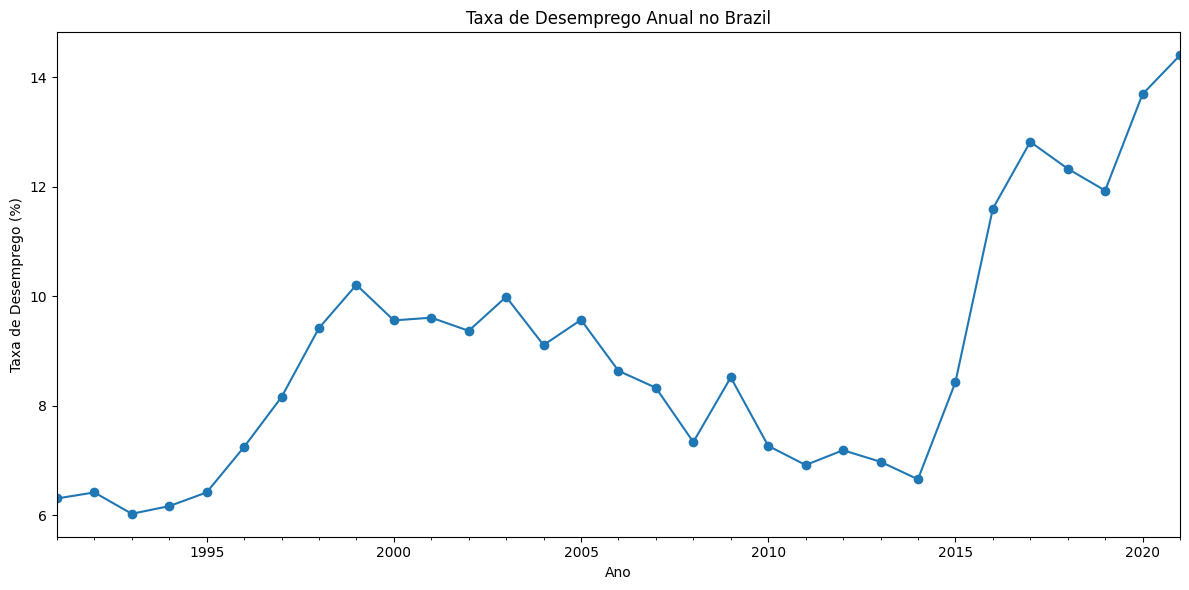

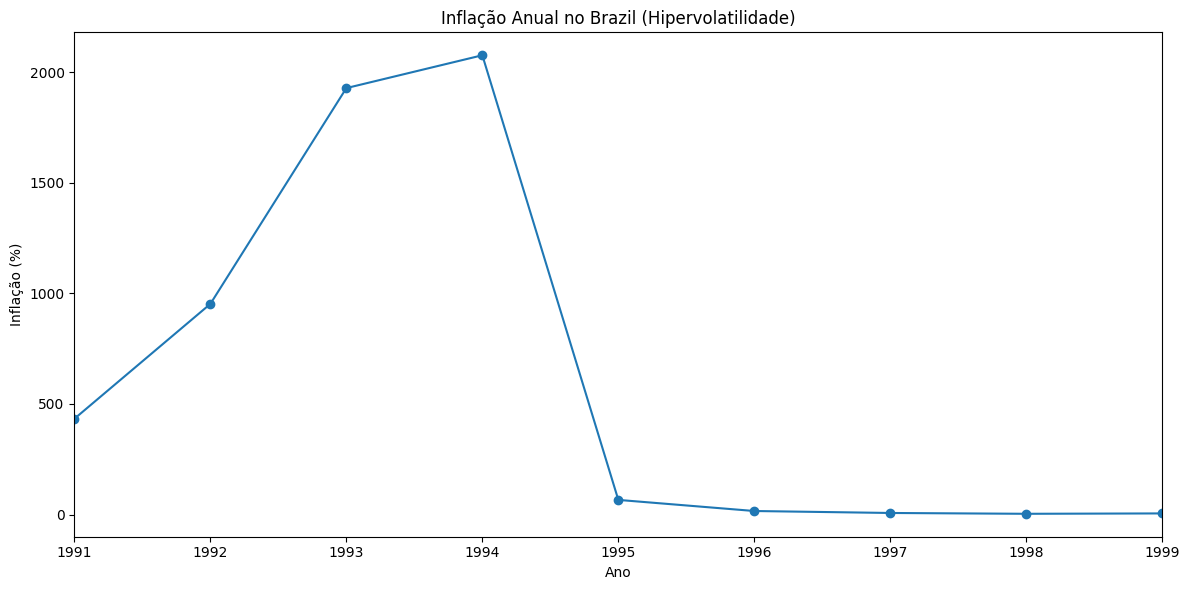

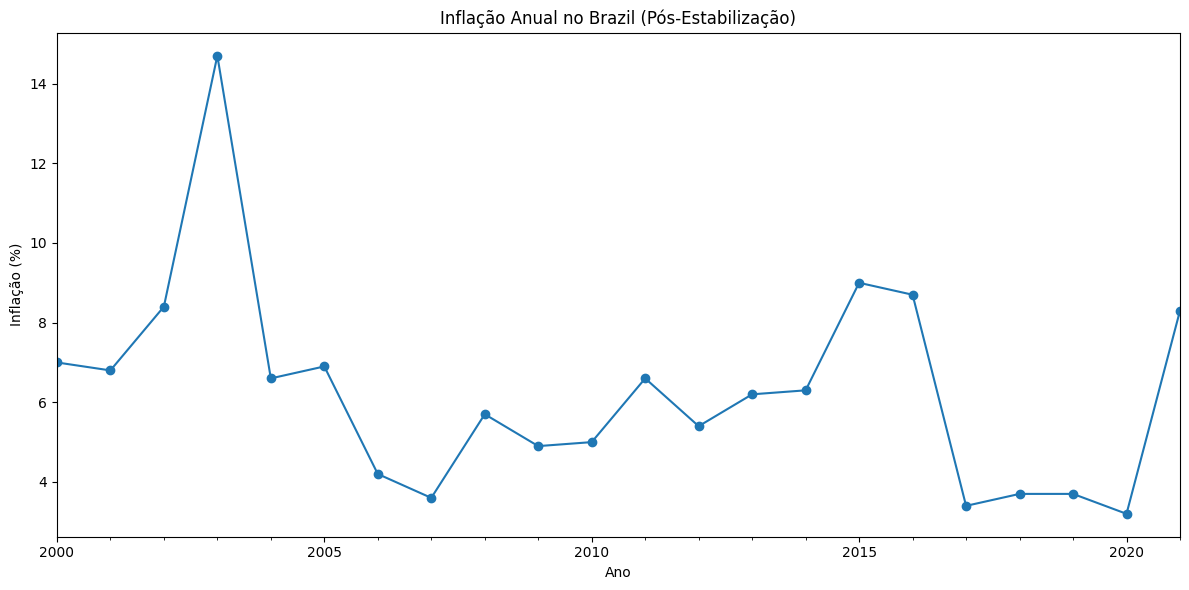

In [15]:
country_name = 'Brazil'
infl_col = 'Brazil_infl'
unemp_col = 'Brazil_unemp'

# Desemprego Anual
plt.figure(figsize=(12, 6))
df_br_general[unemp_col].plot(
    title=f"Taxa de Desemprego Anual no {country_name}",
    xlabel="Ano",
    ylabel="Taxa de Desemprego (%)",
    marker='o'
)
plt.tight_layout()
plt.show()

# Inflação Anual no país
brazil_infl = df_br_general[infl_col].copy()

# Hipervolatilidade (Anos iniciais de 1970 - 1999)
infl_hyper_range = brazil_infl.loc[:'1999-12-31']
plt.figure(figsize=(12, 6))
infl_hyper_range.plot(
    title=f"Inflação Anual no {country_name} (Hipervolatilidade)",
    xlabel="Ano",
    ylabel="Inflação (%)",
    marker='o'
)
plt.tight_layout()
plt.show()

# Pós-Estabilização (2000 em diante)
infl_stable_range = brazil_infl.loc['2000-01-01':]
plt.figure(figsize=(12, 6))
infl_stable_range.plot(
    title=f"Inflação Anual no {country_name} (Pós-Estabilização)",
    xlabel="Ano",
    ylabel="Inflação (%)",
    marker='o'
)
plt.tight_layout()
plt.show()

## Decomposição das Time Series

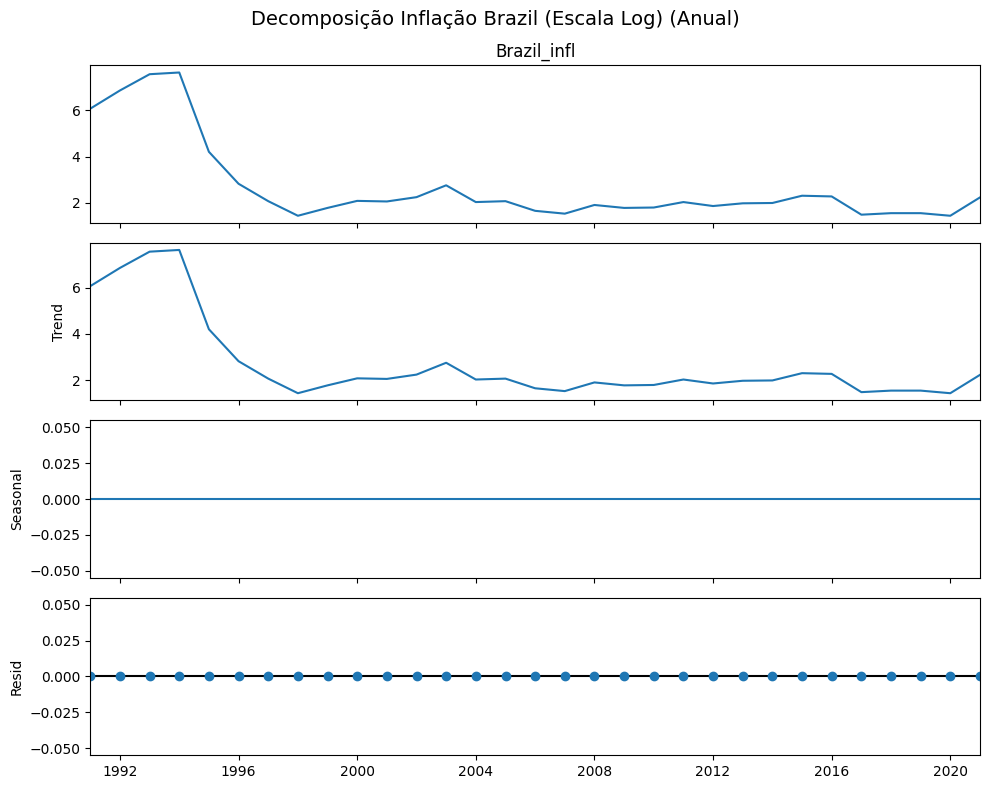

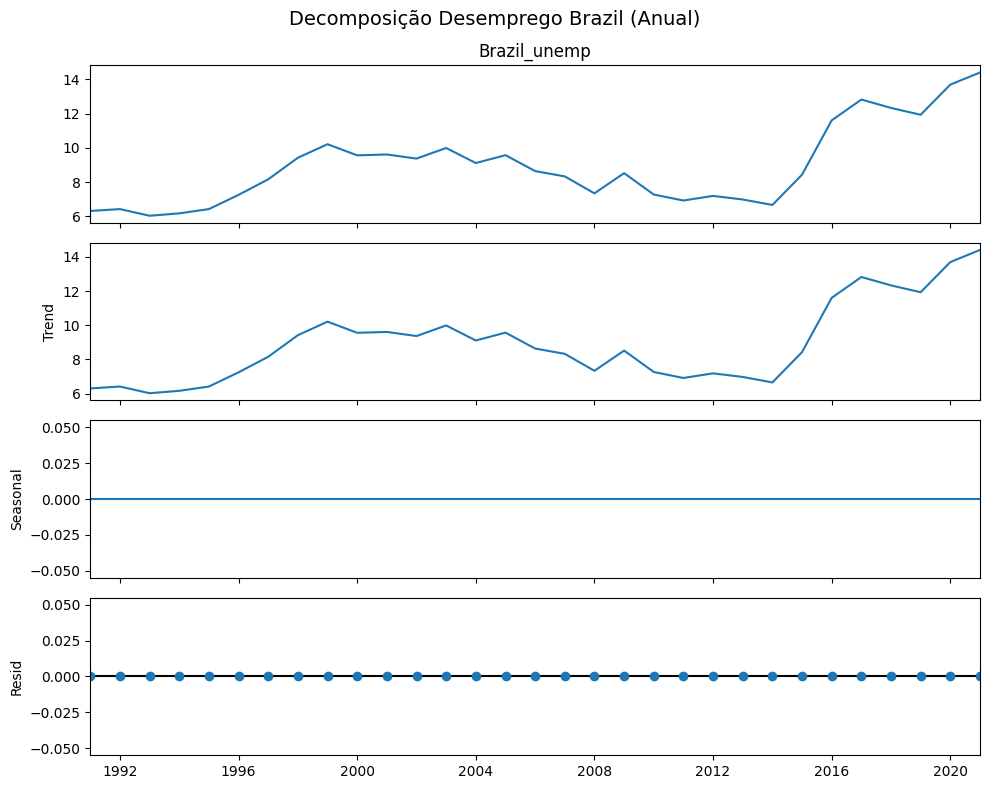

In [16]:
# A decomposição sazonal em séries anuais (período=1)
PERIOD = 1 # Período de 1 ano

# Preencher gaps - valores incorretos
serie_infl = df_br_general[infl_col].copy().ffill().bfill()
serie_unemp = df_br_general[unemp_col].copy().ffill().bfill()

# --- Decomposição da INFLAÇÃO ---

log_note = ""
# Se a série tiver valores muito altos, como é o caso do Brasil para Inflação
if serie_infl.max() > 50:
    serie_infl = np.log1p(serie_infl)
    log_note = "(Escala Log)"

decomp_infl = seasonal_decompose(
    serie_infl,
    model='additive',
    period=PERIOD,
    extrapolate_trend='freq'
)

fig1 = decomp_infl.plot()
fig1.set_size_inches(10, 8)
fig1.suptitle(f"Decomposição Inflação {country_name} {log_note} (Anual)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Decomposição do DESEMPREGO ---
decomp_unemp = seasonal_decompose(
    serie_unemp,
    model='additive',
    period=PERIOD,
    extrapolate_trend='freq'
)

fig2 = decomp_unemp.plot()
fig2.set_size_inches(10, 8)
fig2.suptitle(f"Decomposição Desemprego {country_name} (Anual)", fontsize=14)
plt.tight_layout()
plt.show()

Análise Final (Com Projeção - ARIMA)

Desemprego

 ARIMA(0,1,0)(0,0,0)[0] intercept


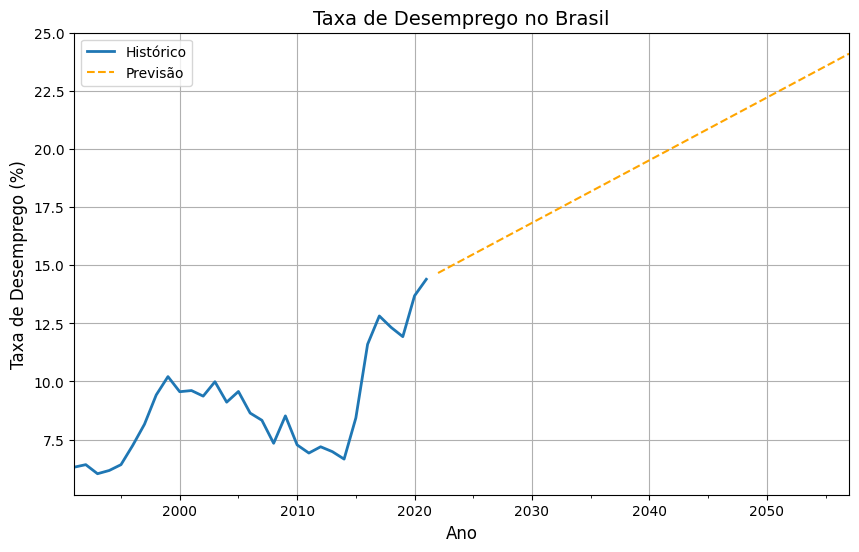

In [17]:
df = pd.read_csv('unemployment analysis.csv')
br = df[df['Country Name']=='Brazil']

br_long = br.melt(
    id_vars=["Country Name", "Country Code"],
    value_vars=[col for col in br.columns if col.isdigit()],
    var_name="year",
    value_name="value"
)

br_long["year"] = br_long["year"].astype(int)
br_long["date"] = pd.to_datetime(br_long["year"], format="%Y")

br_timeseries = br_long[["date", "value"]].sort_values("date").reset_index(drop=True)
br_timeseries.to_csv("brazil_unemployment.csv", index=False)

# índice temporal
df = pd.read_csv('brazil_unemployment.csv', index_col='date', parse_dates=True)

# ARIMA
model = auto_arima(y=df['value'], m=1, seasonal=True)
print(model)

future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1),
                             periods=36, freq="YS")

predictions = pd.Series(model.predict(n_periods=36), index=future_index)

# plotando
plt.figure(figsize=(10,6))
df['value'].plot(label="Histórico", linewidth=2)
predictions.plot(label="Previsão", linestyle="--", color="orange")
plt.title("Taxa de Desemprego no Brasil", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Taxa de Desemprego (%)", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()


Inflação

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=245.209, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=228.706, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=236.889, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=227.324, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=229.308, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=229.315, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=228.549, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=230.927, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=227.333, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.658 seconds
 ARIMA(2,0,0)(0,0,0)[0]          


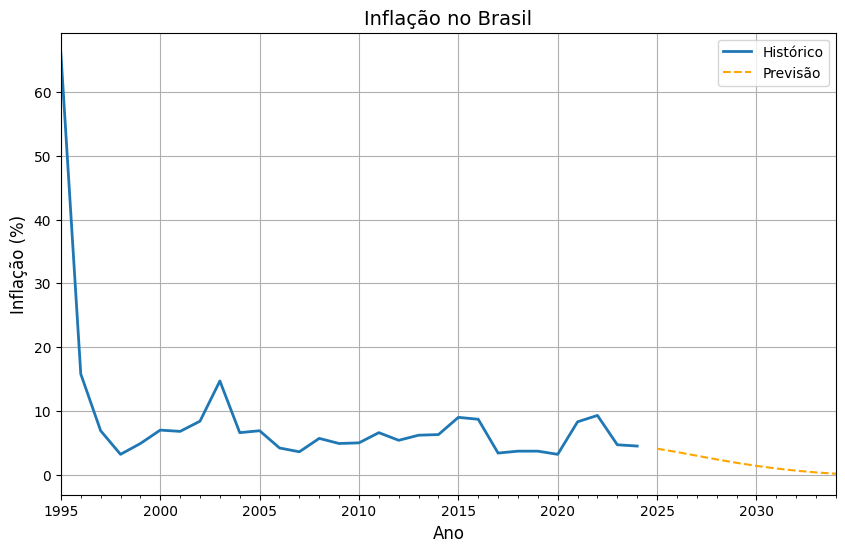

In [18]:
df_infl = pd.read_csv("global_inflation_data.csv")
br_infl = df_infl[df_infl["country_name"] == "Brazil"]

# transformando colunas de anos em formato longo
br_infl_long = br_infl.melt(
    id_vars=["country_name", "indicator_name"],
    value_vars=[col for col in br_infl.columns if col.isdigit()],
    var_name="year",
    value_name="inflation"
)

# ano para datetime
br_infl_long["year"] = br_infl_long["year"].astype(int)
br_infl_long["date"] = pd.to_datetime(br_infl_long["year"], format="%Y")

# criando dataset
br_infl_timeseries = br_infl_long[["date", "inflation"]].sort_values("date").reset_index(drop=True)

# salvando em CSV
br_infl_timeseries.to_csv("brazil_inflation.csv", index=False)
df_infl = pd.read_csv("brazil_inflation.csv", index_col="date", parse_dates=True)

# a partir de 1995
df_infl_recent = df_infl["1995":]

# ARIMA
model_infl = auto_arima(df_infl_recent["inflation"], m=1, seasonal=False, trace=True)
print(model_infl)

future_index = pd.date_range(start=df_infl_recent.index[-1] + pd.DateOffset(years=1),
                             periods=10, freq="YS")

predictions_infl = pd.Series(model_infl.predict(n_periods=10), index=future_index)

# plotando
plt.figure(figsize=(10,6))
df_infl_recent["inflation"].plot(label="Histórico", linewidth=2)
predictions_infl.plot(label="Previsão", linestyle="--", color="orange")

plt.title("Inflação no Brasil", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Inflação (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()